# Evaluation metrics

For this notebook, I will work with two datasets, one for a classification problem (from Kaggle), and the other one for a regression problem (from SciKitLearn).

In [1]:
import os
import sys
import altair as alt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_predict

<br><br>

## 1: The Classification Data
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. We will look at an example is customer churn datasets. Customer churn refers to the notion of customers leaving a subscription service. We will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. We use [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). 


The `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.


> Note that for customer churn problems a more appropriate technique is something called survival analysis, but we'll just treat this problem as a binary classification problem.   

In [2]:
df = pd.read_csv("../downloads/bigml_59c28831336c6604c800002a.csv", encoding="utf-8",)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.head()

state  account length  area code phone number international plan  \
1402    NE              70        415     421-8535                 no   
1855    WI              67        510     417-2265                 no   
633     NJ             122        415     327-9341                 no   
1483    NV             107        510     419-9688                yes   
2638    HI             105        510     364-8128                 no   

     voice mail plan  number vmail messages  total day minutes  \
1402              no                      0              213.4   
1855              no                      0              109.1   
633              yes                     34              146.4   
1483              no                      0              234.1   
2638              no                      0              125.4   

      total day calls  total day charge  ...  total eve calls  \
1402               86             36.28  ...               77   
1855              134             18.55  ...               76   
633               104             24.89  ...              103   
1483               91             39.80  ...              105   
2638              116             21.32  ...               95   

      total eve charge  total night minutes  total night calls  \
1402             17.40                256.6                101   
1855             12.10                 91.2                 86   
633               7.62                220.0                 91   
1483             13.86                282.5                100   
2638             22.23                241.6                104   

      total night charge  total intl minutes  total intl calls  \
1402               11.55                 5.7                 4   
1855                4.10                10.9                 5   
633                 9.90                15.6                 4   
1483               12.71                10.0                 3   
2638               10.87                11.4                 9   

      total intl charge  customer service calls  churn  
1402               1.54                       1  False  
1855               2.94                       2  False  
633                4.21                       2  False  
1483               2.70                       1  False  
2638               3.08                       2  False  

[5 rows x 21 columns]

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1402 to 1346
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null

<br><br>

## 2: Classification Metrics
<hr>

### 2.1 Distribution of target values

We will examine the distribution of target values in the train split.

In [4]:
dist = train_df["churn"].value_counts(normalize=True)
dist

False    0.850407
True     0.149593
Name: churn, dtype: float64

In [5]:
print(f"proportion of True target values is {round(dist[1], 2) * 100}%")

proportion of True target values is 15.0%


This is a churn problem and class imbalance is expected. Only 15% of the target values are positive (True) which indicates a target class imbalance. Accuracy is misleading when we have class imbalance. We usually need to deal with class imbalance but in the case for this dataset it is not too bad and we could ignore it. We could take a look at our precision and recall scores to see if this imbalance is truly affecting the results, and if so, deal with the imbalance.

<br><br>

### 2.2 EDA 


Going through the data I came up with two exploratory questions that I would like to answer and explore:

_Question 1: Is churn lower for customers with longer account length?_   
The bar chart below shows that the distribution of both churn and non-churn targets look normally distributed. I created a normalized stack bar to see if this percentage decreases as the Account length increases. It appears that not! The ratio between these two is almost the same and actually increases towards the end (I have clipped out the outliers from the plot).

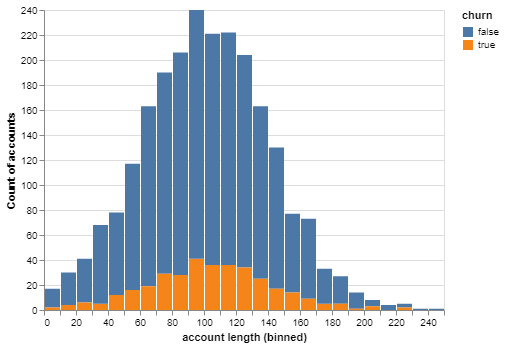

In [6]:
alt.renderers.enable('mimetype')
alt.Chart(train_df).mark_bar().encode(
    x=alt.X("account length", bin=alt.Bin(maxbins=40)),
    y=alt.Y("count()", title="Count of accounts"),
    color="churn"
)

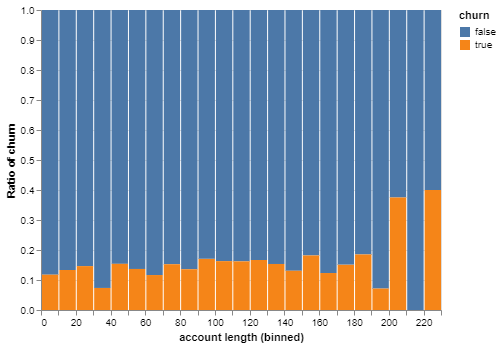

In [7]:
alt.renderers.enable('mimetype')
alt.Chart(train_df).mark_bar(clip=True).encode(
    x=alt.X("account length", bin=alt.Bin(maxbins=40), scale=alt.Scale(domain=(0, 230))),
    y=alt.Y("count()", stack="normalize", title="Ratio of churn"),
    color="churn"
)

_Question 2: Do customers who talk longer on phone in the morning also talk longer at night? Is the talk length pattern different for people of a certain area code?_  
According to the below interactive plot (you may click on the bar chart categories to select mapping on the binned scatter chart_ this feature works when you run the notebook or save the notebook as html), it is obvious that there is no trend between talk time in the day and at night. Also when looking at each area code we don't see at trend and both features seem to be following a similar joint distribution.

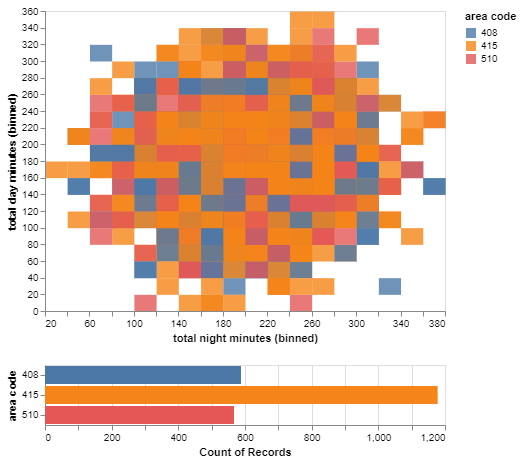

In [8]:
click = alt.selection_multi(fields=["area code"])

scatter = (
    alt.Chart(train_df)
    .mark_rect(opacity=0.8)
    .encode(
        x=alt.X("total night minutes", bin=alt.Bin(maxbins=30)),
        y=alt.Y("total day minutes", bin=alt.Bin(maxbins=30)),
        color=alt.condition(
            click,
            alt.Color("area code:O", scale=alt.Scale(scheme="tableau10")),
            alt.value("lightgrey"),
        ),
    )
)

bar = scatter.mark_bar().encode(
    x="count()",
    y="area code:O",
    opacity=alt.condition(click, alt.value(1), alt.value(0.2)),
)

(scatter & bar).add_selection(click)

<br><br>

### 2.3 Feature transformations 


In preparation for building a classifier, we set up a `ColumnTransformer` that performs feature transformations. By default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.


In [9]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [10]:
X_train.head()

state  account length  area code phone number international plan  \
1402    NE              70        415     421-8535                 no   
1855    WI              67        510     417-2265                 no   
633     NJ             122        415     327-9341                 no   
1483    NV             107        510     419-9688                yes   
2638    HI             105        510     364-8128                 no   

     voice mail plan  number vmail messages  total day minutes  \
1402              no                      0              213.4   
1855              no                      0              109.1   
633              yes                     34              146.4   
1483              no                      0              234.1   
2638              no                      0              125.4   

      total day calls  total day charge  total eve minutes  total eve calls  \
1402               86             36.28              204.7               77   
1855              134             18.55              142.3               76   
633               104             24.89               89.7              103   
1483               91             39.80              163.1              105   
2638              116             21.32              261.5               95   

      total eve charge  total night minutes  total night calls  \
1402             17.40                256.6                101   
1855             12.10                 91.2                 86   
633               7.62                220.0                 91   
1483             13.86                282.5                100   
2638             22.23                241.6                104   

      total night charge  total intl minutes  total intl calls  \
1402               11.55                 5.7                 4   
1855                4.10                10.9                 5   
633                 9.90                15.6                 4   
1483               12.71                10.0                 3   
2638               10.87                11.4                 9   

      total intl charge  customer service calls  
1402               1.54                       1  
1855               2.94                       2  
633                4.21                       2  
1483               2.70                       1  
2638               3.08                       2

In [11]:
binary = ["international plan", "voice mail plan"]
categorical = ["state", "area code"]
drop = ["phone number", "total day charge", "total eve charge", "total night charge", "total intl charge"]
numeric = list(
    set(X_train.select_dtypes("number").columns.tolist())
    - set(drop + ["area code"])
)

- We don't have any NA's and therefore, I don't need to apply imputation.
- I will be applying OHE to the binary list while setting the binary to True.
- For the categorical list, I will apply OHE since the `state` column only has 52 classes, and the `area code` although numerical, is a categorical feature (in a sense that numbers do not represent size) in nature with only 3 distinct values.
- I will drop `phone number` as it is usually assigned randomly.
- I will apply standard scaler transformation on the numeric columns to standardize the range of the values.
- After further review of the values of the features using Pandas profiling report I realized that there is a very high correlation between the total minutes for time periods and charges for that period (which makes sense). I am dropping the features with charges as they wouldn't provide and extra information.

In [12]:
ct = make_column_transformer(
    (OneHotEncoder(drop="if_binary", sparse=True, dtype=int), binary),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=int),
        categorical,
    ),
    (StandardScaler(), numeric),
    ("drop", drop),
    n_jobs=-1,
)

<br><br>

### 2.4 Visualizing the transformed data 


In [13]:
train_df_trans = ct.fit_transform(train_df)
pd.DataFrame(
    train_df_trans.toarray(),
    columns=binary
    + ct.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()
    + numeric,
)

international plan  voice mail plan  state_AK  state_AL  state_AR  \
0                    0.0              0.0       0.0       0.0       0.0   
1                    0.0              0.0       0.0       0.0       0.0   
2                    0.0              1.0       0.0       0.0       0.0   
3                    1.0              0.0       0.0       0.0       0.0   
4                    0.0              0.0       0.0       0.0       0.0   
...                  ...              ...       ...       ...       ...   
2328                 1.0              0.0       0.0       0.0       0.0   
2329                 0.0              1.0       0.0       0.0       0.0   
2330                 0.0              0.0       0.0       0.0       0.0   
2331                 0.0              0.0       0.0       0.0       0.0   
2332                 1.0              0.0       0.0       0.0       0.0   

      state_AZ  state_CA  state_CO  state_CT  state_DC  ...  total day calls  \
0          0.0       0.0       0.0       0.0       0.0  ...        -0.721211   
1          0.0       0.0       0.0       0.0       0.0  ...         1.655252   
2          0.0       0.0       0.0       0.0       0.0  ...         0.169963   
3          0.0       0.0       0.0       0.0       0.0  ...        -0.473663   
4          0.0       0.0       0.0       0.0       0.0  ...         0.764078   
...        ...       ...       ...       ...       ...  ...              ...   
2328       0.0       0.0       0.0       0.0       0.0  ...         1.259175   
2329       0.0       0.0       0.0       0.0       0.0  ...        -1.414346   
2330       0.0       0.0       0.0       0.0       0.0  ...        -1.810423   
2331       0.0       0.0       0.0       0.0       0.0  ...         0.219472   
2332       0.0       0.0       0.0       0.0       0.0  ...        -2.751107   

      total eve calls  customer service calls  total day minutes  \
0           -1.156734               -0.415269           0.618769   
1           -1.207278                0.337507          -1.293778   
2            0.157417                0.337507          -0.609809   
3            0.258506               -0.415269           0.998345   
4           -0.246937                0.337507          -0.994886   
...               ...                     ...                ...   
2328         0.612316                0.337507           0.329045   
2329        -0.398570                1.090282          -0.664820   
2330         1.067214                0.337507           0.048489   
2331         2.381365               -0.415269           0.173180   
2332         0.359594               -0.415269          -0.842689   

      total eve minutes  total night calls  total night minutes  \
0              0.069871           0.052115             1.088667   
1             -1.167277          -0.720990            -2.162302   
2             -2.210130          -0.463288             0.369287   
3             -0.754894           0.000574             1.597736   
4              1.195994           0.206736             0.793839   
...                 ...                ...                  ...   
2328           0.898602           0.206736             1.652771   
2329          -0.618094          -1.648715            -1.440956   
2330          -1.216842          -0.205587            -0.582024   
2331           0.890672           0.309816             0.801701   
2332          -0.265190          -0.566369            -0.379576   

      total intl minutes  account length  number vmail messages  
0              -1.645501       -0.767893              -0.587624  
1               0.227019       -0.843585              -0.587624  
2               1.919489        0.544113               1.900976  
3              -0.097071        0.165650              -0.587624  
4               0.407069        0.115188              -0.587624  
...                  ...             ...                    ...  
2328            0.803179        0.645037              -0.587

<br><br>

### 2.5 area code feature


I had already included `area code` in categorical features. My reasoning was that although we use numbers to represent area code, the size of these numbers imply no meanings and the values are categorical in nature and represent their respective geographical areas. There are 3 unique values for area code only. The created feature columns were the below:

In [14]:
ct.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()[-3:]

['area code_408', 'area code_415', 'area code_510']

In [15]:
train_df["area code"].unique()

array([415, 510, 408], dtype=int64)

<br><br>

### 2.6 Dummy classifier

We create a `DummyClassifier` to get baseline scoring metrics via cross-validation: **accuracy, precision, recall, f1-score, roc_auc, and average precision score**. 

In [16]:
results = {}

In [17]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [18]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]
pipe = make_pipeline(ct, DummyClassifier())
dummy_scores = pd.DataFrame(mean_std_cross_val_scores(pipe, X_train, y_train, scoring=scoring), columns=["Dummy"])
dummy_scores

C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:

Dummy
fit_time                0.224 (+/- 0.476)
score_time              0.221 (+/- 0.443)
test_accuracy           0.850 (+/- 0.001)
test_precision          0.000 (+/- 0.000)
test_recall             0.000 (+/- 0.000)
test_f1                 0.000 (+/- 0.000)
test_roc_auc            0.500 (+/- 0.000)
test_average_precision  0.150 (+/- 0.001)

Precision, recall and f1 all have True Positive in their numerator, but since the dummy classifier classifies everything as the majority target class (which is `False` for this data set), we don't get any True positives, and therefore, these values all become zero. This is called the score being ill-defined. In order to fix this, we need to set zero_division=1 in the precision_score piece and calculate it individually. Due to classfying everything as majority class, we get a accuracy of 0.85. roc_aus was expected because the model is like a diagonal line, and the area under that line is 0.5.

<br><br>

### 2.7 Logistic regression and SVC  

We now try logistic regression and SVC classifiers and examine the confusion matrix given by [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html?highlight=cross_val_predict) for both classifiers. 
We will report the cross-validation scores using the same metrics as in the previous step for both classifiers.

In [19]:
# Logistic Regression
lr_pipe = make_pipeline(ct, LogisticRegression(max_iter=200))
confusion_matrix(y_train, cross_val_predict(lr_pipe, X_train, y_train))

array([[1924,   60],
       [ 276,   73]], dtype=int64)

In [20]:
# SVC
svc_pipe = make_pipeline(ct, SVC())
confusion_matrix(y_train, cross_val_predict(svc_pipe, X_train, y_train))

array([[1968,   16],
       [ 229,  120]], dtype=int64)

In [21]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]

lr_scores = pd.DataFrame(
    mean_std_cross_val_scores(lr_pipe, X_train, y_train, scoring=scoring),
    columns=["Logistic Regression"],
)

svc_scores = pd.DataFrame(
    mean_std_cross_val_scores(svc_pipe, X_train, y_train, scoring=scoring),
    columns=["SVC"],
)

pd.concat([dummy_scores, lr_scores, svc_scores], axis=1)

Dummy Logistic Regression  \
fit_time                0.224 (+/- 0.476)   0.038 (+/- 0.011)   
score_time              0.221 (+/- 0.443)   0.023 (+/- 0.009)   
test_accuracy           0.850 (+/- 0.001)   0.856 (+/- 0.013)   
test_precision          0.000 (+/- 0.000)   0.549 (+/- 0.105)   
test_recall             0.000 (+/- 0.000)   0.209 (+/- 0.046)   
test_f1                 0.000 (+/- 0.000)   0.303 (+/- 0.063)   
test_roc_auc            0.500 (+/- 0.000)   0.797 (+/- 0.020)   
test_average_precision  0.150 (+/- 0.001)   0.439 (+/- 0.051)   

                                      SVC  
fit_time                0.091 (+/- 0.007)  
score_time              0.053 (+/- 0.007)  
test_accuracy           0.895 (+/- 0.007)  
test_precision          0.889 (+/- 0.057)  
test_recall             0.344 (+/- 0.064)  
test_f1                 0.492 (+/- 0.065)  
test_roc_auc            0.893 (+/- 0.021)  
test_average_precision  0.742 (+/- 0.026)

<br><br>

### 2.8 Discussion



1. It seems like Logistic Regression has higher type I and type II errors that SVC. This means that SVC is a better classifier. The number of True positives and true negatives is higher than LR.  
2. SVC is predicting better than Logistic Regression with acceptable precision score and increased recall score in comparison to Logistic Regression. The combined f1 score is therefore higher for the SVC model.

<br><br>

### 2.9 Tackling class imbalance using `class_weight`

1. We try to handle class imbalance by setting `class_weight` parameter to `'balanced'` of the models and report the same metrics as in the previous part. 
2. We will then examine the confusion matrix given by [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html?highlight=cross_val_predict) for both logistic regression and SVC. 

In [22]:
# Logistic Regression
lr_pipe_balanced = make_pipeline(
    ct, LogisticRegression(max_iter=200, class_weight="balanced")
)
confusion_matrix(y_train, cross_val_predict(lr_pipe_balanced, X_train, y_train))

array([[1531,  453],
       [ 105,  244]], dtype=int64)

In [23]:
# SVC
svc_pipe_balanced = make_pipeline(ct, SVC(class_weight="balanced"))
confusion_matrix(y_train, cross_val_predict(svc_pipe_balanced, X_train, y_train))

array([[1807,  177],
       [  98,  251]], dtype=int64)

In [24]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]

lr_scores = pd.DataFrame(
    mean_std_cross_val_scores(lr_pipe_balanced, X_train, y_train, scoring=scoring),
    columns=["Logistic Regression_balanced"],
)

svc_scores = pd.DataFrame(
    mean_std_cross_val_scores(svc_pipe_balanced, X_train, y_train, scoring=scoring),
    columns=["SVC_balanced"],
)

pd.concat([dummy_scores, lr_scores, svc_scores], axis=1)

Dummy Logistic Regression_balanced  \
fit_time                0.224 (+/- 0.476)            0.039 (+/- 0.010)   
score_time              0.221 (+/- 0.443)            0.028 (+/- 0.004)   
test_accuracy           0.850 (+/- 0.001)            0.761 (+/- 0.020)   
test_precision          0.000 (+/- 0.000)            0.351 (+/- 0.024)   
test_recall             0.000 (+/- 0.000)            0.699 (+/- 0.034)   
test_f1                 0.000 (+/- 0.000)            0.467 (+/- 0.023)   
test_roc_auc            0.500 (+/- 0.000)            0.799 (+/- 0.024)   
test_average_precision  0.150 (+/- 0.001)            0.425 (+/- 0.058)   

                             SVC_balanced  
fit_time                0.128 (+/- 0.006)  
score_time              0.060 (+/- 0.004)  
test_accuracy           0.882 (+/- 0.012)  
test_precision          0.588 (+/- 0.035)  
test_recall             0.719 (+/- 0.038)  
test_f1                 0.646 (+/- 0.030)  
test_roc_auc            0.889 (+/- 0.016)  
test_average_precision  0.696 (+/- 0.027)

<br><br>

### 2.10 Discussion 


1. When the class_weight is set to balanced, both True Positive (TP's) and False Positives (FPs) have increased.  
2. We see a major improvement for recall score for both SVC and Logistic Regression (for balanced class weights) causing an improvement in F1 score. The improvement in recall score has respectively brought down the precision score for both models. For this problem we are more interested in higher recall scores because we want to increase the number of TPss for when the label is truly positive. In other words, we want to be able to maximize the true prediction and improve the situation for customers who are more likely to cancel their subscription before it really happens. Since we are willing to risk more false positives in exchange of more true positives, the balanced models with higher recall rate work better for us._

<br><br>

### 2.11 Hyperparameter optimization

We will tune the hyperparameters of our best performing model to maximize cross-validation F1 score, and then report the best hyperparameter values and best cross-validation f1 score.

In [25]:
hyper_pipe = make_pipeline(ct, SVC(probability=True))

params = {
    "svc__C": np.logspace(-3, 1, 5),
    "svc__gamma": np.logspace(-3, 2, 6),
    "svc__class_weight": ["balanced", None],
}

hyper_SVC = RandomizedSearchCV(
    hyper_pipe,
    param_distributions=params,
    n_jobs=-1,
    n_iter=30,
    scoring="f1",
    random_state=101,
)

hyper_SVC.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('onehotencoder-1',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             dtype=<class 'int'>),
                                                                               ['international '
                                                                                'plan',
                                                                                'voice '
                                                                                'mail '
                                                                                'plan']),
                                                                              ('on

In [26]:
hyper_SVC.best_params_

{'svc__gamma': 0.1, 'svc__class_weight': 'balanced', 'svc__C': 1.0}

In [27]:
hyper_SVC.best_score_

0.6337144096153324

<br><br>

### 2.12 Test results


In [28]:
confusion_matrix(y_test, hyper_SVC.predict(X_test))

array([[813,  53],
       [ 39,  95]], dtype=int64)

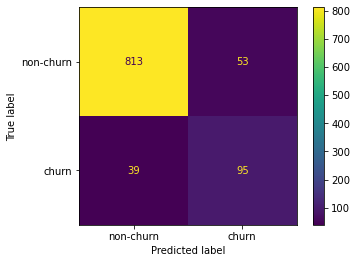

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(
    hyper_SVC, X_test, y_test, values_format="d", display_labels=["non-churn", "churn"]
)

In [30]:
print(
    classification_report(
        y_test, hyper_SVC.predict(X_test), target_names=["non-churn", "churn"]
    )
)

              precision    recall  f1-score   support

   non-churn       0.95      0.94      0.95       866
       churn       0.64      0.71      0.67       134

    accuracy                           0.91      1000
   macro avg       0.80      0.82      0.81      1000
weighted avg       0.91      0.91      0.91      1000



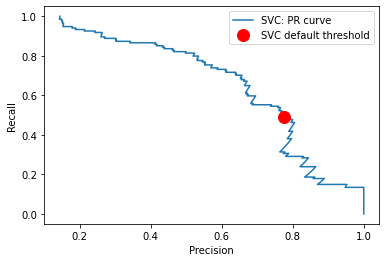

In [31]:
from sklearn.metrics import precision_recall_curve
# Inspired by MDS lecture notes

precision_SVC, recall_SVC, thresholds_SVC = precision_recall_curve(
    y_test, hyper_SVC.predict_proba(X_test)[:,1]
)

close_default_SVC = np.argmin(np.abs(thresholds_SVC - 0.5))

label="SVC: PR curve"
marker_colour="r"
marker_label="SVC default threshold"

plt.plot(precision_SVC, recall_SVC, label=label)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_SVC[close_default_SVC],
    recall_SVC[close_default_SVC],
    "o",
    markersize=12,
    label=marker_label,
    c=marker_colour,
)
plt.legend(loc="best");

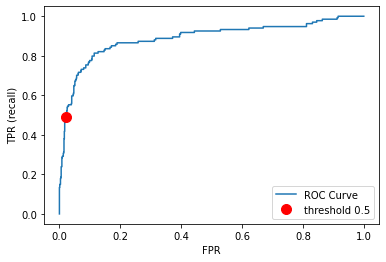

In [32]:
from sklearn.metrics import roc_curve
# Inspired by MDS lecture notes

fpr, tpr, thresholds = roc_curve(y_test, hyper_SVC.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [33]:
from sklearn.metrics import roc_auc_score

roc_lr = roc_auc_score(y_test, hyper_SVC.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.889


Looking at the classification report, we are interested in the precision, recall and f1-score for the `churn` row as it is our `positive` class. The f1 score on our test set is pretty close to the best f1-score we got in our RandomizedSearchCV and in fact a bit better which shows that our model has generalized well. The recall score of 0.82 seems reasonable considering that we wanted to increase the percentage of capturing the churn class when they are truly churn (in order to improve our service for those customers before losing them).  

The high AUC for ROC indicates that the two target classes are well distinguished by our SVC model, and if the decision was to improve recall to above 0.8 we could do so with a small expense on False positive rate.  
From the PR curve we can see that a higher recall like 0.80 was required, we could achive so by lowering the SVC threshold to a value like 0.25 (I have done these calculations in the background). It is worthy to remind that setting the target class_weight to "balanced" has already created the same effect for us.

<br><br><br><br>

## 3: Regression metrics
<hr> 


For this second exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. 

In [34]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame
housing_df.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010

In [35]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### 3.1 Data spitting and exploration 


In [36]:
X_train, X_test, y_train, y_test = train_test_split(housing_df.drop("MedHouseVal", axis = 1), housing_df["MedHouseVal"], test_size=0.2, random_state=2021)

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 2782 to 6201
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      16512 non-null  float64
 1   HouseAge    16512 non-null  float64
 2   AveRooms    16512 non-null  float64
 3   AveBedrms   16512 non-null  float64
 4   Population  16512 non-null  float64
 5   AveOccup    16512 non-null  float64
 6   Latitude    16512 non-null  float64
 7   Longitude   16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [38]:
X_train.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16512.000000  16512.000000  16512.000000  16512.000000  16512.000000   
mean       3.865719     28.599019      5.434371      1.099138   1427.285489   
std        1.893223     12.615809      2.587655      0.496437   1146.895638   
min        0.499900      1.000000      0.846154      0.333333      6.000000   
25%        2.568575     18.000000      4.433962      1.006260    788.000000   
50%        3.531750     29.000000      5.226145      1.048830   1165.000000   
75%        4.733050     37.000000      6.050929      1.099417   1727.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  16512.000000  16512.000000  16512.000000  
mean       3.064318     35.637277   -119.572842  
std       10.623352      2.136066      2.002757  
min        0.692308     32.540000   -124.350000  
25%        2.431015     33.930000   -121.790000  
50%        2.817415     34.260000   -118.500000  
75%        3.284547     37.720000   -118.010000  
max     1243.333333     41.950000   -114.310000

In [39]:
all_cols = X_train.columns.tolist()
preprocessor = StandardScaler()

<br><br>

### 3.2 Baseline: DummyRegressor 


In [40]:
dummy_pipe = make_pipeline(preprocessor, DummyRegressor())
dummy_results = pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, return_train_score=True)).mean()
pd.DataFrame(dummy_results, columns=["Dummy"])

Dummy
fit_time     0.006998
score_time   0.001805
test_score  -0.000247
train_score  0.000000

_The default scoring method for DummyRegressor is $R^2$._

<br><br>

### 3.3 Different regressors - Custom scorer

We are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).    

We will define a custom scorer called `mape_scorer` which is the percentage difference from the target. We will then create dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 



In [41]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [42]:
result_scores = pd.DataFrame()
for name, model in models.items():
    cv_pipe = make_pipeline(preprocessor, model)
    results = pd.DataFrame(
        cross_validate(cv_pipe, X_train, y_train, scoring=score_types_reg, n_jobs=-1)
    ).mean()
    result_scores = pd.concat(
        [result_scores, pd.DataFrame(results, columns=[name])], axis=1
    )

result_scores

Ridge  Random Forest
fit_time                           0.023843      12.103467
score_time                         0.005401       0.128132
test_neg_mean_squared_error       -0.533472      -0.259473
test_neg_root_mean_squared_error  -0.730246      -0.509362
test_neg_mean_absolute_error      -0.531489      -0.333247
test_r2                            0.596637       0.803803
test_mape_scorer                 -31.716536     -18.768024

Although it takes much longer to fit the Random Forest model, its score time is reasonable and has better scores across all metrics when compared to Ridge. Both these models perform better than the DummyRegressor.

<br><br>

### 3.4 Hyperparameter optimization  

We will carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. We will see if we are getting better scores compared to the default values.

In [43]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

ridge_pipe = make_pipeline(preprocessor, Ridge(max_iter=200))

ridge_cv = RandomizedSearchCV(ridge_pipe, param_dist, n_iter=20, scoring = "r2")

ridge_cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('ridge', Ridge(max_iter=200))]),
                   n_iter=20,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018E9EC17310>},
                   scoring='r2')

In [44]:
ridge_cv.best_params_

{'ridge__alpha': 15.596429713652231}

In [45]:
ridge_cv.best_score_

0.5967208244758316

The R2 score is almost identical to the R2 score given by default alpha for Ridge.

In [46]:
# Second method
from sklearn.linear_model import RidgeCV

alphas = 10.0 ** np.arange(-3, 3, 1)
ridgecv_pipe = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         cv=10))])

In [47]:
ridgecv_pipe.named_steps["ridgecv"].alpha_

100.0

<br><br>

### 3.5 Test results

Next we will try the best model on the test set.

In [48]:
best_pipe = make_pipeline(preprocessor, RandomForestRegressor())

best_pipe.fit(X_train, y_train)
best_pipe.score(X_test, y_test)

0.8128115473220212

In [49]:
# More detailed score analysis
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error is {mean_squared_error(y_test, best_pipe.predict(X_test))}")
print(f"Root mean squared error is {np.sqrt(mean_squared_error(y_test, best_pipe.predict(X_test)))}")
print(f"R2 score is {r2_score(y_test, best_pipe.predict(X_test))}")
print(f"MAPE score is {mape(y_test, best_pipe.predict(X_test))}")

Mean squared error is 0.25583600156721575
Root mean squared error is 0.5058023344817774
R2 score is 0.8128115473220212
MAPE score is 18.273974987685897


According to the above scores which are very close to the cross_validation scores calculated in 3.3, we can say that this model will generalize well on the deployment data. The R2 score seems reasonable and the MAPE score of 18.41% average difference from target sounds good.

<br><br>

### 3.6 Model interpretation  

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. We will:

- Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. From 3.4, we use the `Ridge` model with best hyperparameters.  
- According to the model, we will explore that increasing which feature values would result in higher housing price. 

In [50]:
best_ridge = make_pipeline(preprocessor, Ridge(alpha = ridge_cv.best_params_['ridge__alpha']))
best_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=15.596429713652231))])

In [51]:
features = X_train.columns.tolist()
coefficients = best_ridge.named_steps['ridge'].coef_.tolist()

pd.DataFrame({"features": features, "coefficients": coefficients}).sort_values("coefficients", ascending=False)

features  coefficients
0      MedInc      0.825681
3   AveBedrms      0.324469
1    HouseAge      0.116178
4  Population     -0.002682
5    AveOccup     -0.041229
2    AveRooms     -0.278527
7   Longitude     -0.862288
6    Latitude     -0.890808

From the sorted table above we can see that Median Income and Average number of bedrooms have the highest coefficients, and therefore, more likely to contribute the most to the housing price if increase.